# **CSE 422 Lab: Decision Tree**

---
A **Decision tree** is a Supervised Learning Algorithm which has a tree like structure, where each internal node asks a question on an attribute, each branch represents an outcome of the question, and each leaf node (terminal node) holds a class label.

In order to build a decision tree from a given dataset, we first need to decide on which feature to split on (which feature to ask the question on). There are a few metrics that we use to determine the best feature to split on at each depth. They are: Information gain, Entropy, Gini Index, and so on. We will be using **Entropy** for today's lab.


# **Entropy**

---
In any decision tree, the most important part is creating a sequence of splits. The rule of split is to separate the data into two groups that are the purest. It means that any group should have similar type of elements as much as possible.

To illustrate, If we have 10 green balls in one basket then it is a pure group. On the other hand, if we have 3 green balls, 5 blue balls and 2 red balls in one bucket then it is an unpure group.

Entropy's value is ranged between 0 to 1. 0 means full pure group and 1 means maximum unpure group. Lower entrophy means better purity.

The way to measure the pureness is by calculating the Entropy of the data.

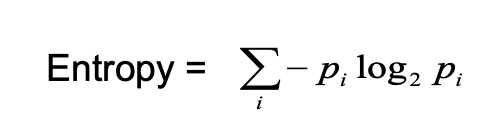

In [ ]:
###defining entropy
def entropy(target_col):
    elements,counts = np.unique(target_col,return_counts=True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy

# **Information Gain**

---

Information Gain is calculated for a split by subtracting the weighted entropies of each branch from the original entropy. When training a Decision Tree using these metrics, the best split is chosen by maximizing Information Gain.

### **Formula**

---

 **Information Gain = Entropy(Parent) - [Weighted Average] * Entropy(children)**

In [ ]:
##Information Gain

def InfoGain(data,split_attribute_name,target_name="class_type"):
    total_entropy = entropy(data[target_name])
    vals,counts = np.unique(data[split_attribute_name],return_counts=True)
    #calculating the weighted entropy
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).
                                dropna()[target_name])for i in range(len(vals))])
    
    #Calculating infomation gain
    Information_Gain = total_entropy-Weighted_Entropy
    return Information_Gain

# **ID3 Algorithm**

---
ID3 stands for Iterative Dichotomiser 3. This algorithm iteratively divideds features into two or more groups at each step.


*   Calculating each feature's information gain.
*   Split the dataset using subset which has maximum information gain.
*   Buidling decision tree node using maximum information gain.
*   If all the rows belong to the same class then make that a leaf node.
*   Repeat the process for rest of the features.










In [ ]:
def ID3(data,originaldata,features,target_attribute_name="class_type", parent_node_class=None):
    #If all target_values have the same value, return this value
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    
    #if the dataset is empty
    elif len(data) == 0:
        return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],
                                                                           return_counts=True)[1])]
    
    #If the feature space is empty
    elif len(features) == 0:
        return parent_node_class 

    #If none of the above condition holds true grow the tree

    else:
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],
                                                                           return_counts=True)[1])]

    #Select the feature which best splits the dataset
    item_values = [InfoGain(data,feature,target_attribute_name)for feature in features] #Return the infogain values
    best_feature_index = np.argmax(item_values)
    best_feature = features[best_feature_index]

    #Create the tree structure
    tree = {best_feature:{}}

    #Remove the feature with the best info gain
    features = [i for i in features if i!= best_feature]

    #Grow the tree branch under the root node

    for value in np.unique(data[best_feature]):
        value = value
        sub_data = data.where(data[best_feature]==value).dropna()
        #Recursive call of ID3 algotirthm
        subtree = ID3(sub_data,dataset,features,target_attribute_name,parent_node_class)
        #adding subtree to the main tree
        tree[best_feature][value] = subtree
    return(tree)

In [ ]:
#Predict
def predict(query,tree,default=1):
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
               result = tree[key][query[key]]
            except:
               return default

            result = tree[key][query[key]]
            if isinstance(result,dict):
                return predict(query,result)
            else:
                return result

In [ ]:
def train_test_split(dataset):
    training_data = dataset.iloc[:80].reset_index(drop=True)
    testing_data = dataset.iloc[80:].reset_index(drop=True)
    return training_data,testing_data


def test(data,tree):
   queries = data.iloc[:,:-1].to_dict(orient="records")
   predicted = pd.DataFrame(columns=["predicted"])

   #Accuracy calculation

   for i in range(len(data)):
       predicted.loc[i,"predicted"] = predict(queries[i],tree,1.0)
   print("Accuracy Score:",(np.sum(predicted["predicted"]==data["class_type"])/len(data))*100,'%')

In [ ]:
import pandas as pd
import numpy as np
from pprint import pprint

#import the dataset
dataset = pd.read_csv("/content/zoo.csv")
#animal name is unnecessary
dataset = dataset.drop('animal_name',axis=1)


training_data = train_test_split(dataset)[0]
testing_data = train_test_split(dataset)[1]

tree = ID3(training_data,training_data,training_data.columns[:-1])
pprint(tree)
test(testing_data,tree)


{'legs': {0: {'fins': {0.0: {'toothed': {0.0: 7.0, 1.0: 3.0}},
                       1.0: {'eggs': {0.0: 1.0, 1.0: 4.0}}}},
          2: {'hair': {0.0: 2.0, 1.0: 1.0}},
          4: {'hair': {0.0: {'toothed': {0.0: 7.0, 1.0: 5.0}}, 1.0: 1.0}},
          6: {'aquatic': {0.0: 6.0, 1.0: 7.0}},
          8: 7.0}}
The Prediction accuracy is: 85.71428571428571 %


Using Scikit Learn Library

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
animal = pd.read_csv("zoo.csv")
from sklearn.model_selection import train_test_split
X = animal.iloc[:,1:17]
y = animal.iloc[:,17]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)
clf = DecisionTreeClassifier(criterion='entropy',random_state=1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
score=accuracy_score(y_pred,y_test)
print(score)

0.9523809523809523


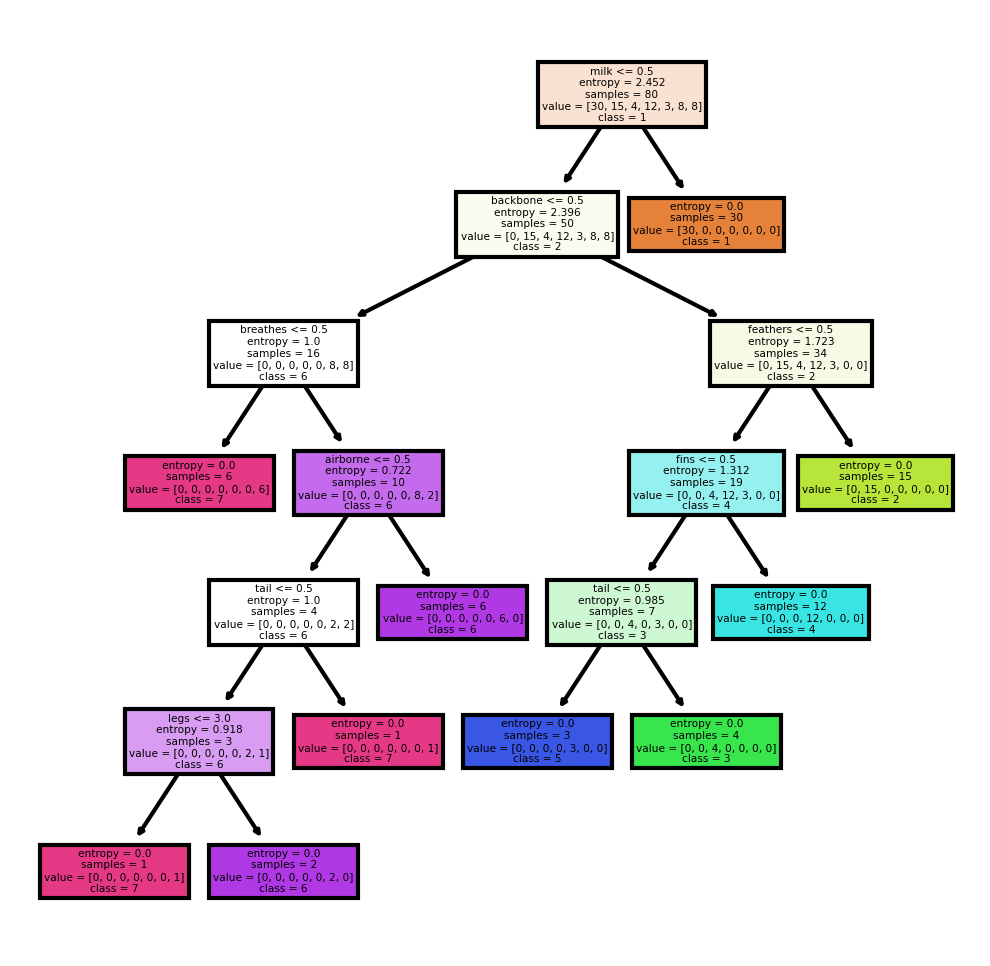

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf,
               feature_names = X.columns, 
               class_names=['1','2','3','4','5','6','7'],
               filled = True);

# **References:**

---



1.   https://www.youtube.com/watch?v=UdTKxGQvYdc
2.   https://www.youtube.com/watch?v=9r7FIXEAGvs
3.   https://towardsdatascience.com/decision-trees-for-classification-id3-algorithm-explained-89df76e72df1


